In [5]:
%reset
import pandas as pd
import numpy as np
import h5py
import datetime
from data_processing_func import df_creator
from sklearn.metrics import roc_auc_score, roc_curve, brier_score_loss
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split



In [6]:
def df_creator(file_path, trades):                                                                   #Create an orderbook dataframe for every month/seperate h5 file.
    data_file = h5py.File(file_path,'r')                                                     #Use h5py package to read in the h5 file.
    df_total = pd.DataFrame(data = np.array(data_file['/data/block0_values']))          #Create a DataFrame containing all the values in the orderbook
    if trades == True:
        df_total.columns = [str(c).replace("b'", "").replace("'", "") for c in np.array(data_file['/data/block0_items']).tolist()]
    elif trades == False:
        df_total.columns = [str(c).replace("b'", "").replace("'", "").replace(":","_").split("|", 1)[0] for c in np.array(data_file['/data/block0_items']).tolist()]
    df_index= pd.DataFrame(data = np.array(data_file['/data/axis1']))   
    df_total['timestamp'] = df_index.loc[:]
    df_total.index = pd.to_datetime(df_total.timestamp,unit='ns')
    df_total = df_total.drop(columns=['timestamp'])
    return df_total 

In [7]:
file_path_ob = "/Users/markdekwaasteniet/Documents/Master Finance/Master Thesis/BTC_Data/mark_ob.h5" 
file_path_trades = "/Users/markdekwaasteniet/Documents/Master Finance/Master Thesis/BTC_Data/mark_trades.h5"
orderbook_data = df_creator(file_path_ob, False)
trades_data = df_creator(file_path_trades, True)

# columns_dict = {'volume':1, 'type':2, 'price':0}
# df_trade_volume = trades_data.copy()
# for c, i in columns_dict.items():
#     df_trade_volume[c] = np.nan
#     df_trade_volume[c] = df_trade_volume.iloc[:,i].values

# df_trade_volume = df_trade_volume.iloc[:,3:]

In [8]:
def ROC_curve(model,y_test,x_test):
    plt.figure(figsize=(10,10))
    ns_probs = [0 for _ in range(len(y_test))]

    # predict probabilities using the soft voting classifier model
    targets_proba_pred = model.predict_proba(x_test)[::,1]

    # calculate roc curves
    ns_fpr, ns_tpr, _ = roc_curve(y_test, ns_probs)
    lr_fpr, lr_tpr, _ = roc_curve(y_test, targets_proba_pred)
    # plot the roc curve for the model
    plt.plot(ns_fpr, ns_tpr, linestyle='--', label='No Skill')
    plt.plot(lr_fpr, lr_tpr, marker='.', label='Soft Voting Classifier Model')

    # axis labels
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')

    # show the legend
    plt.legend()

    # show the plot
    plt.show()
    
    print(f"Area Under the ROC: {roc_auc_score(y_test, targets_proba_pred)}")
    print(f"Brier Score: {brier_score_loss(y_test, targets_proba_pred)}")


def make_cf_matrix(model, X_test, y_test):
    y_pred = model.predict(X_test)
    cf_matrix = confusion_matrix(y_test, y_pred)

    ax = sns.heatmap(cf_matrix, annot=True, cmap='Blues')

    ax.set_title('Seaborn Confusion Matrix with labels\n\n');
    ax.set_xlabel('\nPredicted Values')
    ax.set_ylabel('Actual Values ');

    ## Ticket labels - List must be in alphabetical order
    ax.xaxis.set_ticklabels(['False','True'])
    ax.yaxis.set_ticklabels(['False','True'])

    ## Display the visualization of the Confusion Matrix.
    plt.show()

In [9]:
def order_placement(df_orders_placed, c):
    df_orders_placed.loc[(df_orders_placed['sold_orders'] > 0), 'order_subtraction'] = -df_orders_placed['sold_orders']

    df_orders_placed.loc[(df_orders_placed['quantity_change'] < 0) & (abs(df_orders_placed['quantity_change']) > abs(df_orders_placed['sold_orders']))
                        & (df_orders_placed["order_price"] == df_orders_placed[str(c) + "_price_shift"]), 'order_subtraction'] = df_orders_placed['quantity_change']
    if c == "bid":
        df_orders_placed.loc[(df_orders_placed["order_price"] < df_orders_placed[str(c) + "_price_shift"]), 'order_subtraction'] = -df_orders_placed['order_quantity']
    elif c == "ask":
        df_orders_placed.loc[(df_orders_placed["order_price"] > df_orders_placed[str(c) + "_price_shift"]), 'order_subtraction'] = -df_orders_placed['order_quantity']

    df_orders_placed['order_subtraction'] = df_orders_placed['order_subtraction'].fillna(0)
    
    df_orders_placed.loc[(df_orders_placed['quantity_change'] > 0), 'order_placed'] = (df_orders_placed['sold_orders'] + df_orders_placed['quantity_change'])
    df_orders_placed.loc[((df_orders_placed['quantity_change'] < 0) & (abs(df_orders_placed['quantity_change']) < abs(df_orders_placed['sold_orders']))), 'order_placed'] = (df_orders_placed['sold_orders'] + df_orders_placed['quantity_change'])
    return df_orders_placed

def threshold_finder(placed_order, df_orders_placed, order_size = False): 
    if order_size == False:
        threshold = df_orders_placed.loc[str(placed_order.timestamp)].order_quantity
    else: 
        threshold = (df_orders_placed.loc[str(placed_order.timestamp)].order_quantity - df_orders_placed.loc[str(placed_order.timestamp)].order_placed) + order_size
    
    df_cumsum = df_orders_placed.loc[str(placed_order.timestamp):].iloc[1:,:]

    running_sum = 0
    for future_date in range(1, len(df_cumsum)):
        running_sum += abs(df_cumsum.loc[df_cumsum.index[future_date], 'order_subtraction'])
        try:
            if running_sum >= threshold:
                if df_cumsum.loc[df_cumsum.index[future_date], 'sold_orders'] > 0:
                    return df_cumsum.loc[df_cumsum.index[future_date], 'timestamp']
        except:
            return np.nan

def volume_summation(placed_order, df_orders_placed, column):
    past_minute = placed_order.timestamp - datetime.timedelta(seconds=1)
    df_past_volume = df_orders_placed.loc[str(past_minute):str(placed_order.timestamp)].iloc[:,:]
    return df_past_volume[column].sum()
            
def execution_date(df_orders_placed, size_vector):

    mask = (df_orders_placed['order_placed'] > 0)
    for make_size in size_vector[:-1]:
        df_orders_placed.loc[mask, ('timestamp_execution_' + str(make_size))] = df_orders_placed.loc[mask].apply(lambda placed_order: threshold_finder(placed_order, df_orders_placed, float(make_size)), axis=1)
    
    df_orders_placed.loc[mask, ('timestamp_execution_full')] = df_orders_placed.loc[mask].apply(lambda placed_order: threshold_finder(placed_order, df_orders_placed), axis=1)
    df_orders_placed.loc[mask, 'past_taking_volume'] = df_orders_placed.loc[mask].apply(lambda placed_order: volume_summation(placed_order, df_orders_placed, "sold_orders"), axis=1)
    df_orders_placed.loc[mask, 'past_making_volume'] = df_orders_placed.loc[mask].apply(lambda placed_order: volume_summation(placed_order, df_orders_placed, "order_placed"), axis=1)
    
    return df_orders_placed

def keep_columns(df, c):
    df = df.iloc[:,5:]
    df = df.drop(columns=[str(c) + "_price_shift"])
    return df

def calc_bid_ask_spread(df):
    spread = df['asksP_0'] - df['bidsP_0']
    return spread

def unweighted_mid_price(df):
    price = (df['asksP_0'] + df['bidsP_0']) / 2
    return price

def VWAP(df):
    price =  ((df['bidsP_0']*df['bidsQ_0']) + (df['asksP_0']*df['asksQ_0'])) / (df['asksQ_0'] + df['bidsQ_0'])
    return price

def micro_price(df):
    price =  ((df['bidsP_0']*df['asksQ_0']) + (df['asksP_0']*df['bidsQ_0'])) / (df['asksQ_0'] + df['bidsQ_0'])
    return price

def calc_imbalance(df):
    return (df['bidsQ_0'] / df['asksQ_0'])

    
def deep_price(df, column_P, column_Q,split_point,coins):                                                           #A function to calculate the quantity weighted average mid-point price
    df_coins = {}                                                                                                   #Create dictionary to store the price of every coin seperately
    for i in range(0,int(len(coins))):                                                                              #Loop over the number of coins in the dataset: in our example this is 6
        df_order_book = df.iloc[:,((split_point*2)*i):((split_point*2)+(split_point*2)*i)]                          #Create a df of 40 columns every loop, which contain bid prices, bid quantities, ask prices, ask quantities
        
        thresh_Q = list(coins.values())[i]                                                                          #Set the quantity threshold for a certain coin. Based on its name index in the dictionary "coins"                                                                          
                                                                                                                    #XRP is the first coin, so index is 0. Resulting in a quantity of 4500 XRP --> approx 2000 USD.
        def price_calc(df_split):
            price = []
            for index, row in df_split.iterrows():                                                                  #Iterate over the splitted dataframe which contains only bids or asks (quantity and prices)
                if df_split.iloc[index,column_Q] >= thresh_Q:                                                       #If quantity is above the determined threshold, take the first bid/ask price
                    true_price = df_split.iloc[index,column_P] * thresh_Q                                           #price will be multiplied by threshold, at the end of the loop it will be divided by same quantity.
                
                else:
                    quantity = thresh_Q                                                                             #If quantity is not above the determine threshold, create while loop in which it will calculate weighted price
                    book_dept = 0                                                                                   #Book_dept indicates the number of steps the prices has gone into the orderbook.
                    true_price = 0                                                                                  #True price is considered the quantity weighted price
                    
                    while quantity > 0:                                                                             #While the quantity is not yet equal to the threshold, go deeper into orderbook
                        if quantity > df_split.iloc[index,book_dept+column_Q]:                                      #If quantity available is smaller than (still) required quantity for threshold:
                            true_price += (df_split.iloc[index,book_dept]*df_split.iloc[index,book_dept+column_Q])  #Multiply price by the available quantity
                            quantity -= df_split.iloc[index,book_dept+column_Q]                                     #Reduce the required quantity by the available quantity that is bought
                            
                            if book_dept < 9:                                                                       #If the end of the orderbook is not yet met.
                                book_dept += 1                                                                      #Take another step into the orderbook
                            else:
                                true_price += df_split.iloc[index,book_dept]*quantity                               #If the end of the orderbook is met, use the last quantity/price to fill the rest of the required quantity.
                                quantity -= df_split.iloc[index,book_dept+column_Q]                                 #Reduce the required quantity by the available quantity that is bought, which in this case is all.
                                break                                                                               #Break the fore loop en determine next price
                            
                        else:
                            true_price += df_split.iloc[index,book_dept]*quantity                                   #If the quantity available is larger than the still required quantity for threshold, buy rest of quantity needed at this price
                            break                                                                                   #Break the fore loop en determine next price   
                
                weighted_price = true_price / thresh_Q                                                              #prices have been multiplied by threshold quantity, to get the actual price back, divide it by Threshold_Q
                price.append(weighted_price)                                                                        #Append the price to the list of prices
            return price
        
        bid_price = price_calc(df_order_book.iloc[:,:split_point])                                                  #Return the deep prices in the form of a list
        ask_price = price_calc(df_order_book.iloc[:,split_point:])
        
        #df_coins[list(coins.keys())[i]] =  (np.array(bid_price) + np.array(ask_price)) / 2                          #Calculate the weighted average mid point, by taking the averages of the bid and ask deep prices

    return ((np.array(bid_price[:(len(df)-1)]) + np.array(ask_price[:(len(df)-1)])) / 2)
    #return pd.DataFrame.from_dict(df_coins)  

def additional_variables(df, df_orderbook, coins):
    df['spread'] = calc_bid_ask_spread(df_orderbook)
    df['deep_price'] = deep_price(df_orderbook.reset_index(drop=True), 0, 10, 20, coins) #.BTC
    df['unweighted_price'] = unweighted_mid_price(df_orderbook)
    df['micro_price'] = micro_price(df_orderbook)
    df['volume_weighted_price'] = VWAP(df_orderbook)
    df['inventory_bid'] = df_orderbook.iloc[:,10:20].sum(axis=1)
    df['inventory_ask'] = df_orderbook.iloc[:,30:40].sum(axis=1)
    df['imbalance'] = calc_imbalance(df_orderbook)
    return df


In [166]:
def calc_execution_time(df_trades, df_orderbook, coins, execution_sec, size_vector):
    df_check = {}
    df_descriptive = {}
    #Handelen vanuit investors perspectief. Dus -1 = investor verkoopt tegen beste bid. 
    types_dict = {"bid":-1, "ask":1}
    columns_list = ['sold_orders', 'order_subtraction', 'order_placed']
    
    df_trades_executed = pd.DataFrame(index = df_trades.index)

    for c, item in types_dict.items():
        df_trades_executed[c] = df_trades.loc[df_trades['buy'] == item].volume

        df_orders_placed = df_orderbook[str(c) + "sQ_0"].diff().rename("quantity_change")
        
        take_orders_sorted = df_trades_executed[c].groupby(df_orderbook.index[df_orderbook.index.searchsorted(df_trades_executed[c].index)]).sum()
        df_orders_placed = df_orders_placed.to_frame().join(take_orders_sorted.to_frame())

        df_orders_placed = df_orders_placed.reset_index()
        df_orders_placed['timestamp_shift'] = df_orders_placed.timestamp.shift(-1).dropna()
        df_orders_placed = df_orders_placed.iloc[:(len(df_orderbook)-1),:]

        df_orders_placed[columns_list] = np.nan
        
        df_orders_placed['sold_orders'] = df_orders_placed[c].fillna(0)
        df_orders_placed = df_orders_placed.drop(columns=c)
        
        df_orders_placed = df_orders_placed.set_index(df_orders_placed.timestamp)

        df_orders_placed['order_price'] = df_orderbook[str(c) + "sP_0"]
        df_orders_placed[str(c) + "_price_shift"] = df_orders_placed[df_orders_placed.columns[-1]].shift(-1)
        df_orders_placed['order_quantity'] = df_orderbook[str(c) + "sQ_0"]

        df_orders_placed = order_placement(df_orders_placed, c)
        df_orders_placed = execution_date(df_orders_placed, size_vector)
        df_orders_placed['type_order'] = item

        df_orders_placed = keep_columns(df_orders_placed, c)


        df_orders_placed = additional_variables(df_orders_placed, df_orderbook, coins).reset_index()
        df_descriptive[c] = additional_variables(df_orders_placed, df_orderbook, coins)
        df_check[c] = df_orders_placed[df_orders_placed['order_placed'].notna()]

    df_descriptive = pd.concat([df_descriptive['bid'],df_descriptive['ask']], ignore_index=True)
    df_merged = pd.concat([df_check['bid'],df_check['ask']], ignore_index=True)
    for make_size in size_vector:
        df_merged["timestamp_execution_" + str(make_size)]= pd.to_datetime(df_merged["timestamp_execution_" + str(make_size)])
        df_merged["execution_" + str(make_size)] = 0
        df_merged.loc[(df_merged["timestamp_execution_" + str(make_size)] - df_merged['timestamp'] < datetime.timedelta(seconds=execution_sec)), "execution_" + str(make_size)] = 1
        df_merged = df_merged.drop(columns=["timestamp_execution_" + str(make_size)])

    return df_merged.drop(columns=['timestamp']), df_descriptive
    #return df_merged

In [167]:
COINS = {'BTC':0.1}
EXECUTION_SEC = 2
SIZE_VECT = [0.00001,0.0001,0.001,0.01,0.1,1, "full"]
df, df_descriptive = calc_execution_time(trades_data, orderbook_data, COINS, EXECUTION_SEC, SIZE_VECT)
df

,order_placed,order_price,order_quantity,past_taking_volume,past_making_volume,type_order,spread,deep_price,unweighted_price,micro_price,...,inventory_bid,inventory_ask,imbalance,execution_1e-05,execution_0.0001,execution_0.001,execution_0.01,execution_0.1,execution_1,execution_full
0,0.500,44564.4,21.022,0.011,0.500,-1,NaN,44564.4500,NaN,NaN,...,NaN,NaN,NaN,0,0,0,0,0,0,0
1,0.001,44564.4,21.023,0.011,0.501,-1,NaN,44564.4500,NaN,NaN,...,NaN,NaN,NaN,0,0,0,0,0,0,0
2,0.033,44564.4,21.056,0.011,0.534,-1,NaN,44564.4500,NaN,NaN,...,NaN,NaN,NaN,0,0,0,0,0,0,0
3,0.304,44564.4,21.116,0.011,0.838,-1,NaN,44564.4500,NaN,NaN,...,NaN,NaN,NaN,0,0,0,0,0,0,0
4,0.400,44564.4,21.413,0.011,1.238,-1,NaN,44564.4500,NaN,NaN,...,NaN,NaN,NaN,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7760,0.023,44550.0,0.126,0.204,0.023,1,NaN,44549.9500,NaN,NaN,...,NaN,NaN,NaN,1,1,1,1,0,0,1
7761,0.001,44550.0,0.127,0.000,0.024,1,NaN,44549.9500,NaN,NaN,...,NaN,NaN,NaN,1,1,1,0,0,0,1
7762,0.001,44551.7,0.001,0.127,0.025,1,NaN,44552.1855,NaN,NaN,...,NaN,NaN,NaN,0,0,0,0,0,0,0
7763,0.491,44551.7,0.492,0.127,0.493,1,NaN,44551.6500,NaN,NaN,...,NaN,NaN,NaN,0,0,0,0,0,0,0


In [194]:
time_inbetween = (df_descriptive[df_descriptive['type_order'] == -1].timestamp.shift(-1) - df_descriptive[df_descriptive['type_order'] == -1].timestamp).mean()

In [199]:
time_inbetween.mean()

Timedelta('0 days 00:00:00.033757120')

In [190]:
time_inbetween

0       0 days 00:00:00.039229
1       0 days 00:00:00.032725
2       0 days 00:00:00.033011
3       0 days 00:00:00.033182
4       0 days 00:00:00.032255
                 ...          
35541   0 days 00:00:00.032731
35542   0 days 00:00:00.033508
35543   0 days 00:00:00.032539
35544   0 days 00:00:00.033095
35545                      NaT
Name: timestamp, Length: 35546, dtype: timedelta64[ns]

In [208]:
df_period_stats = pd.DataFrame(index = [0,1,2], columns = ['Sample Date','Observations', 'Avg Frequency', 'Volatility', 'Make Orders'])

In [256]:
df_period_stats = pd.DataFrame(index = [0,1,2], columns = ['Sample Date','Observations', 'Avg Frequency', 'Volatility', 'Make Orders'])

for i in range(0,3):
    df_period_stats.iloc[i,0] = df_descriptive.timestamp[0]
    df_period_stats.iloc[i,1] = len(orderbook_data)
    df_period_stats.iloc[i,2] = (df_descriptive[df_descriptive['type_order'] == -1].timestamp.shift(-1) - df_descriptive[df_descriptive['type_order'] == -1].timestamp).mean()
    df_period_stats.iloc[i,3] = round(df_descriptive.deep_price.std(),4)
    df_period_stats.iloc[i,4] = len(df)

df_period_stats['Avg Frequency'] = df_period_stats['Avg Frequency'].astype(str).map(lambda x: x[13:-3])
df_period_stats['Avg Frequency'] = df_period_stats['Avg Frequency'].astype(str) + " seconds"

In [259]:
print(df_period_stats.to_latex(index=True))

\begin{tabular}{llllll}
\toprule
{} &                 Sample Date & Observations &      Avg Frequency & Volatility & Make Orders \\
\midrule
0 &  2022-03-27 10:30:00.020911 &        17774 &  00.033757 seconds &    10.3209 &        7765 \\
1 &  2022-03-27 10:30:00.020911 &        17774 &  00.033757 seconds &    10.3209 &        7765 \\
2 &  2022-03-27 10:30:00.020911 &        17774 &  00.033757 seconds &    10.3209 &        7765 \\
\bottomrule
\end{tabular}



In [ ]:
print(df.to_latex(index=False))

In [14]:
df.head(60)

,order_placed,order_price,order_quantity,past_taking_volume,past_making_volume,type_order,spread,deep_price,unweighted_price,micro_price,...,inventory_bid,inventory_ask,imbalance,execution_1e-05,execution_0.0001,execution_0.001,execution_0.01,execution_0.1,execution_1,execution_full
0,5.000000e-01,44564.4,21.022,0.011,0.500,-1,0.1,44564.4500,44564.45,44564.499044,...,27.348,0.424,103.556650,0,0,0,0,0,0,0
1,1.000000e-03,44564.4,21.023,0.011,0.501,-1,0.1,44564.4500,44564.45,44564.499048,...,27.349,0.584,104.074257,0,0,0,0,0,0,0
2,3.300000e-02,44564.4,21.056,0.011,0.534,-1,0.1,44564.4500,44564.45,44564.499050,...,26.883,1.084,104.237624,0,0,0,0,0,0,0
3,3.040000e-01,44564.4,21.116,0.011,0.838,-1,0.1,44564.4500,44564.45,44564.499472,...,26.966,0.917,188.535714,0,0,0,0,0,0,0
4,4.000000e-01,44564.4,21.413,0.011,1.238,-1,0.1,44564.4500,44564.45,44564.499480,...,27.263,0.917,191.187500,0,0,0,0,0,0,0
5,2.070000e-01,44564.4,21.620,0.011,1.445,-1,0.1,44564.4500,44564.45,44564.499485,...,27.376,0.917,193.035714,0,0,0,0,0,0,0
6,4.000000e-01,44564.4,22.018,0.002,1.344,-1,0.1,44564.4500,44564.45,44564.499462,...,27.774,0.998,185.025210,0,0,0,0,0,0,0
7,4.000000e-03,44564.4,22.022,0.002,1.315,-1,0.1,44564.4500,44564.45,44564.499463,...,27.778,1.021,185.058824,0,0,0,0,0,0,0
8,5.000000e-03,44564.4,22.027,0.002,1.320,-1,0.1,44564.4500,44564.45,44564.499463,...,27.783,1.021,185.100840,0,0,0,0,0,0,0
9,2.500000e-02,44564.4,22.052,0.002,1.041,-1,0.1,44564.4500,44564.45,44564.499441,...,27.808,1.026,177.838710,0,0,0,0,0,0,0


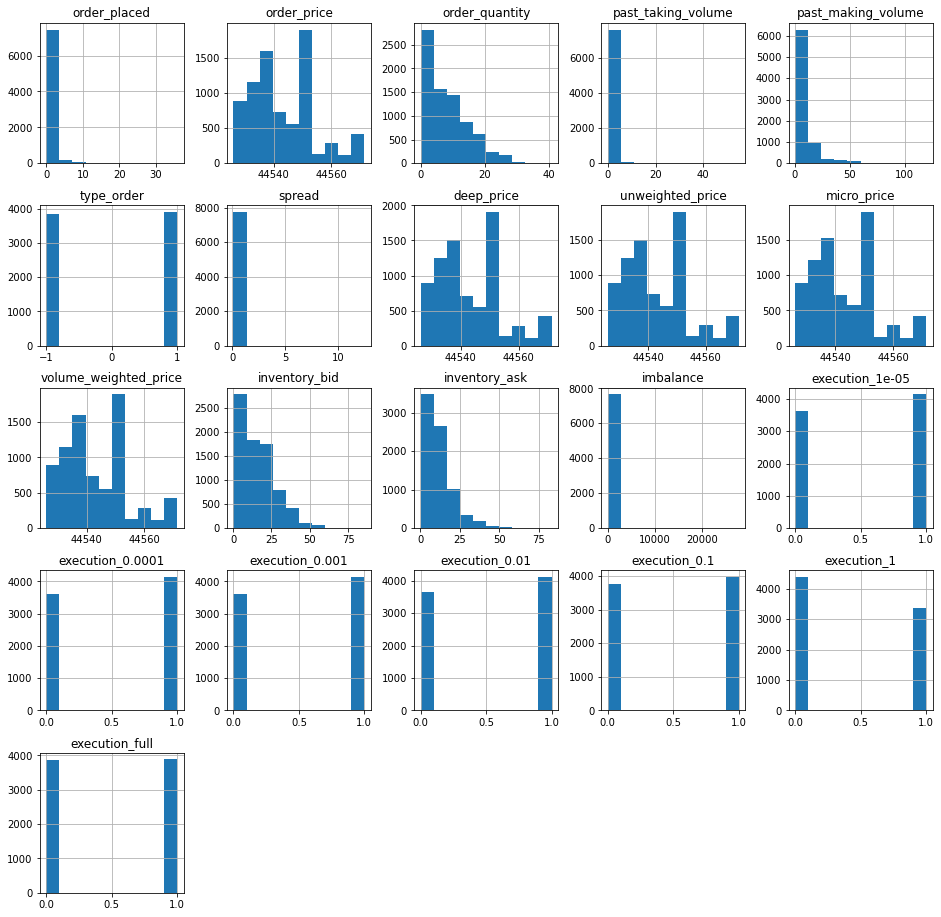

In [15]:
plt.style.use('fast')
df.hist(figsize=(16, 16));

### Method 1: Log Transformation

In [16]:
df_log = df.iloc[:,:-7].copy()
df_log["past_taking_volume"] = df_log["past_taking_volume"] + 1
df_log["past_making_volume"] = df_log["past_making_volume"] + 1
skewed_variables = ["order_placed", "order_price", "order_quantity", "past_taking_volume", "past_making_volume" , "spread",
                    "deep_price", "unweighted_price", "micro_price", "volume_weighted_price", "inventory_bid", "inventory_ask", "imbalance", ]
df_log[skewed_variables] = np.log(df_log[skewed_variables])


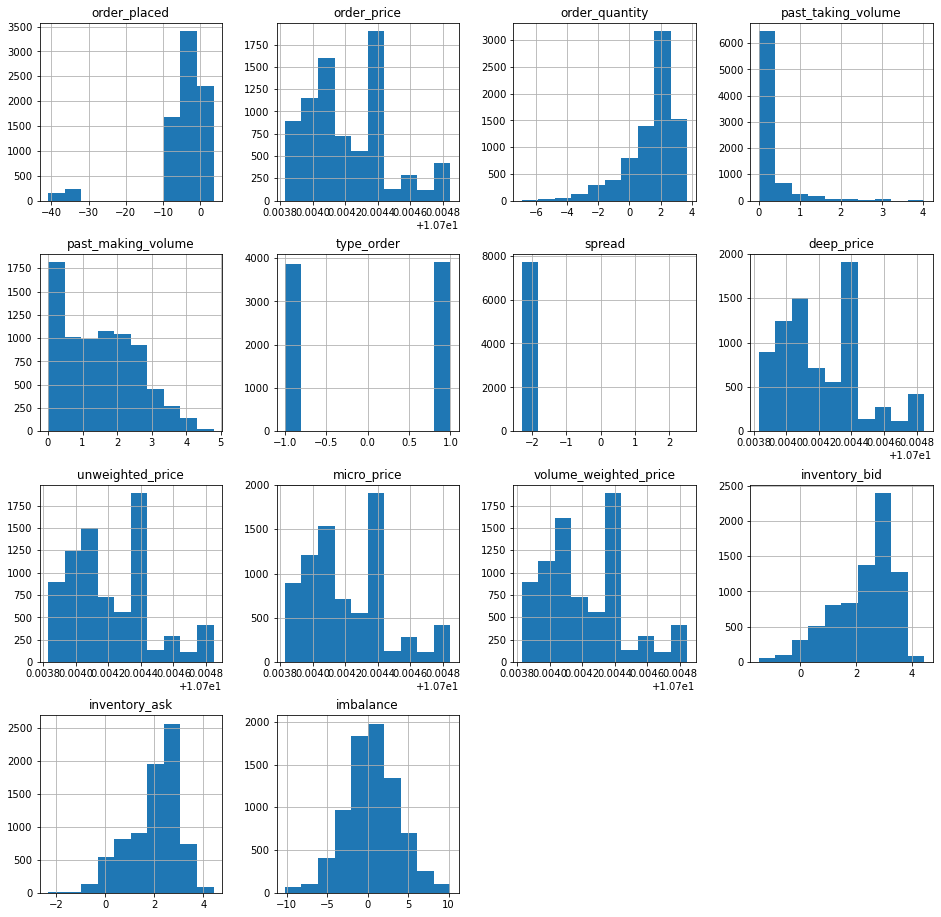

In [17]:
df_log.hist(figsize=(16, 16));

### Method 2: Robust Standardization

In [18]:
from sklearn.preprocessing import RobustScaler

df_robust_std = df.iloc[:,:-7].copy()
df_robust_std[df_robust_std.columns] = RobustScaler().fit_transform(df_robust_std[df_robust_std.columns])

df_robust_std[df_robust_std < -4] = np.nan
df_robust_std[df_robust_std > 4] = np.nan
df_robust_std = df_robust_std.fillna(df_robust_std.mean())

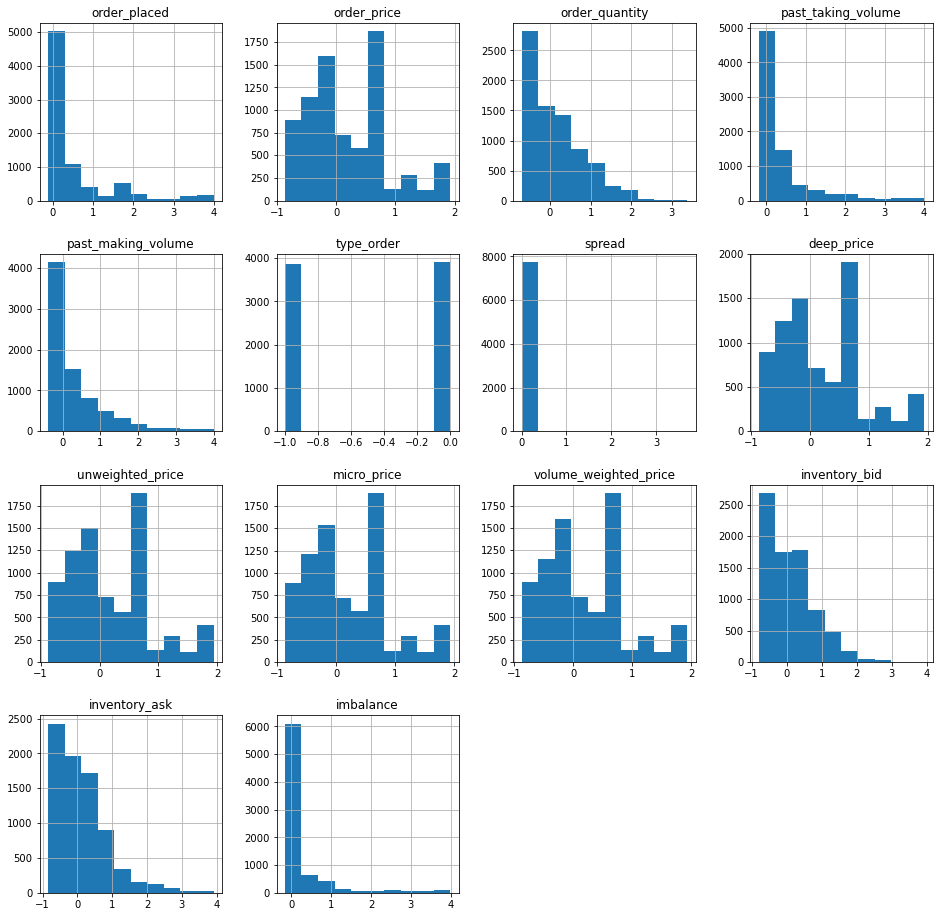

In [19]:
df_robust_std.hist(figsize=(16, 16));

### Method 3: Log Transformation and Standardization

In [20]:
log_sr_features = df.iloc[:,:-7].copy()
log_sr_features["past_taking_volume"] = log_sr_features["past_taking_volume"] + 1
log_sr_features[skewed_variables]  = (np.log(log_sr_features[skewed_variables]))
log_sr_features[log_sr_features.columns] = RobustScaler().fit_transform(log_sr_features[log_sr_features.columns])

log_sr_features[log_sr_features < -4] = np.nan
log_sr_features[log_sr_features > 4] = np.nan
log_sr_features = log_sr_features.fillna(log_sr_features.mean())

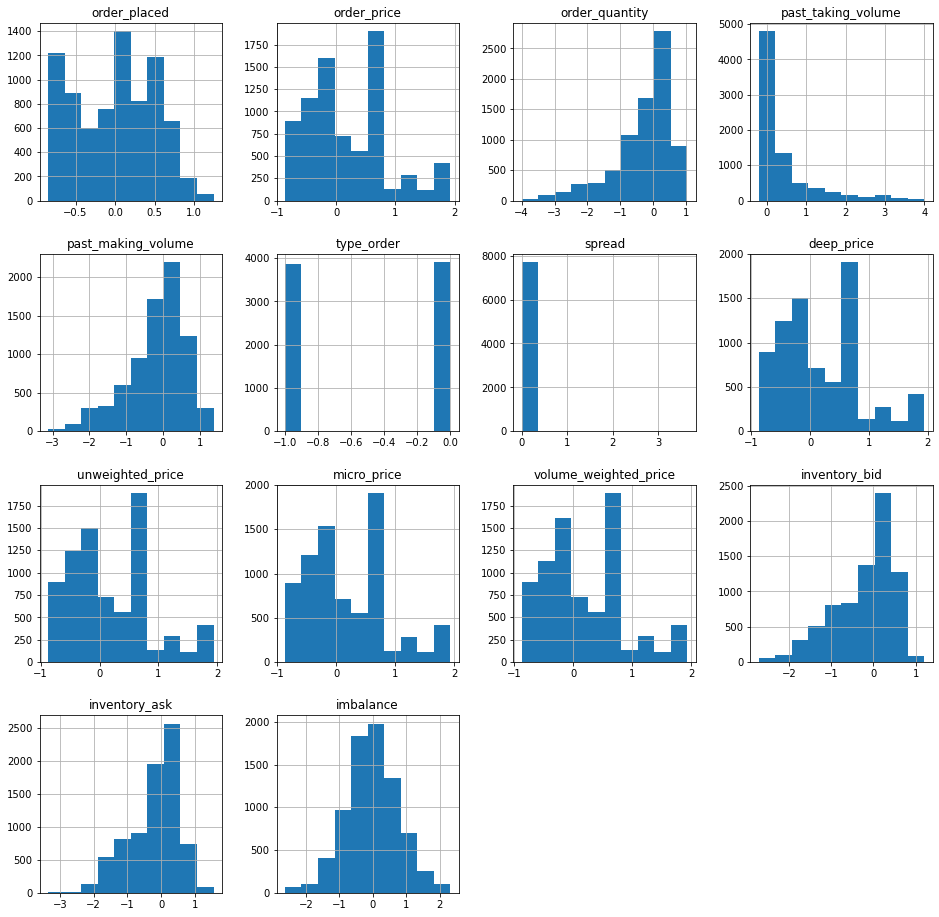

In [21]:
log_sr_features.hist(figsize=(16, 16));

#### Normal Data Set

In [22]:
y = df['execution_full']
X = df.iloc[:,:-7]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.4, random_state=42)

clf = LogisticRegression(random_state=0).fit(X_train, y_train)
clf.score(X_test, y_test)

0.49291693496458466

#### Log Transformed Data Set

In [25]:
y = df['execution_full']
X = df_log
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.4, random_state=42)

clf = LogisticRegression(random_state=0).fit(X_train, y_train)
clf.score(X_test, y_test)

0.6355441081777206

#### Robust Standardized Data Set

In [28]:
y = df['execution_full']
X = df_robust_std
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.4, random_state=42)

clf = LogisticRegression(random_state=0).fit(X_train, y_train)
round(clf.score(X_test, y_test),4)

0.6201

#### Robust and Log Transformed Data Set

In [29]:
y = df['execution_full']
X = log_sr_features
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.4, random_state=42)

clf = LogisticRegression(random_state=0).fit(X_train, y_train)
clf.score(X_test, y_test)

0.6519639407598197

In [30]:
classes = df.iloc[:,14:]
X = log_sr_features

for c in classes.columns:
    y = df[c]
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.4, random_state=42)
    clf = LogisticRegression(random_state=0, max_iter=1000).fit(X_train, y_train)
    print(f"Score of {c} class: {round(clf.score(X_test, y_test),4)}")

Score of execution_1e-05 class: 0.6626
Score of execution_0.0001 class: 0.6626
Score of execution_0.001 class: 0.6623
Score of execution_0.01 class: 0.6632
Score of execution_0.1 class: 0.6542
Score of execution_1 class: 0.6542
Score of execution_full class: 0.652


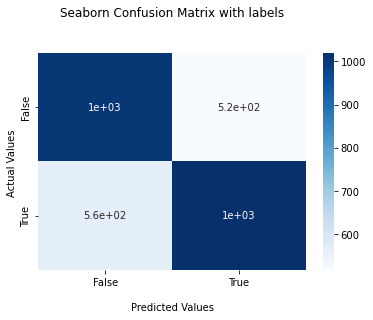

In [31]:
make_cf_matrix(clf, X_test, y_test)

#### Random Forest with Normal Data

In [24]:
y = df['execution_full']
X = df.iloc[:,:-7]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.4, random_state=42)

regr = RandomForestClassifier(max_depth=100, random_state=0).fit(X_train, y_train)
regr.score(X_test, y_test)

0.886349001931745

In [25]:
classes = df.iloc[:,14:]
X = df.iloc[:,:-7]

for c in classes.columns:
    y = df[c]
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.4, random_state=42)
    regr = RandomForestClassifier(max_depth=100, random_state=0).fit(X_train, y_train)
    print(f"Score of {c} class: {regr.score(X_test, y_test)}")

Score of execution_1e-05 class: 0.8921442369607212
Score of execution_0.0001 class: 0.8921442369607212
Score of execution_0.001 class: 0.8943979394719896
Score of execution_0.01 class: 0.8869929169349646
Score of execution_0.1 class: 0.8802318094011591
Score of execution_1 class: 0.8795878943979395
Score of execution_full class: 0.886349001931745


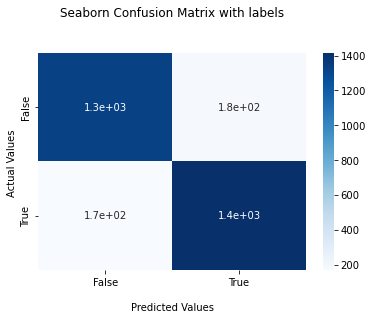

In [26]:
make_cf_matrix(regr, X_test, y_test)

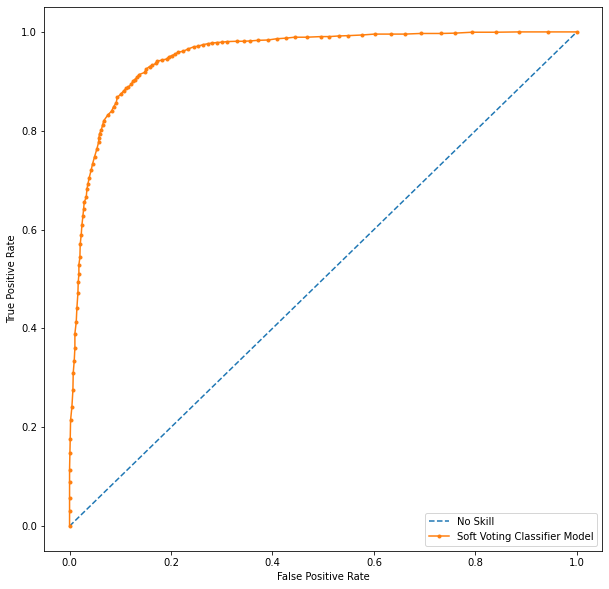

Area Under the ROC: 0.9529173967002482
Brier Score: 0.08914732775273664


In [149]:
y = df['execution_full']
X = df.iloc[:,:-7]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.4, random_state=42)

regr = RandomForestClassifier(max_depth=100, random_state=0).fit(X_train, y_train)
regr.score(X_test, y_test)

ROC_curve(regr,y_test,X_test)

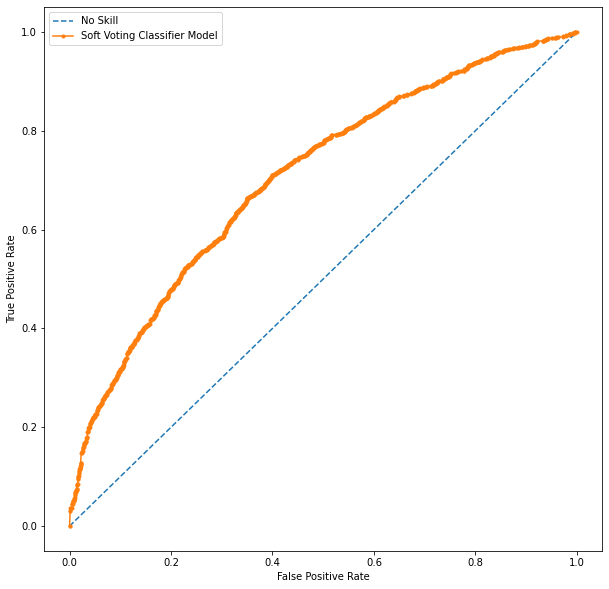

Area Under the ROC: 0.7067467546688966
Brier Score: 0.21861641509333507


In [160]:
y = df['execution_full']
X = log_sr_features
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.4, random_state=42)

clf = LogisticRegression(random_state=0).fit(X_train, y_train)
clf.score(X_test, y_test)

ROC_curve(clf,y_test,X_test)

In [161]:
from scipy.stats import norm

def logit_pvalue(model, x):
    """ Calculate z-scores for scikit-learn LogisticRegression.
    parameters:
        model: fitted sklearn.linear_model.LogisticRegression with intercept and large C
        x:     matrix on which the model was fit
    This function uses asymtptics for maximum likelihood estimates.
    """
    p = model.predict_proba(x)
    n = len(p)
    m = len(model.coef_[0]) + 1
    coefs = np.concatenate([model.intercept_, model.coef_[0]])
    x_full = np.matrix(np.insert(np.array(x), 0, 1, axis = 1))
    ans = np.zeros((m, m))
    for i in range(n):
        ans = ans + np.dot(np.transpose(x_full[i, :]), x_full[i, :]) * p[i,1] * p[i, 0]
    vcov = np.linalg.inv(np.matrix(ans))
    se = np.sqrt(np.diag(vcov))
    t =  coefs/se  
    p = (1 - norm.cdf(abs(t))) * 2
    return p

Feature: order_placed, Score: 0.48087
Feature: order_price, Score: -0.15313***
Feature: order_quantity, Score: -0.82460
Feature: past_taking_volume, Score: -0.01668***
Feature: past_making_volume, Score: 0.58872
Feature: type_order, Score: -0.04588***
Feature: spread, Score: 0.09668
Feature: deep_price, Score: -0.42599
Feature: unweighted_price, Score: 0.14094
Feature: micro_price, Score: 0.19004
Feature: volume_weighted_price, Score: 0.09126
Feature: inventory_bid, Score: -0.27394
Feature: inventory_ask, Score: -0.19386***
Feature: imbalance, Score: -0.02449**


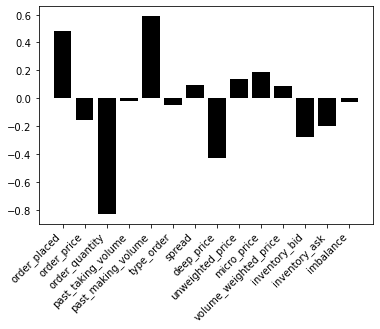

In [162]:
importance = clf.coef_[0]
pvalue_list = logit_pvalue(clf, X_train)
# summarize feature importance
for i,v in enumerate(X.columns):
	if pvalue_list[i] < 0.01:
		print('Feature: %0s, Score: %.5f***' % (v,importance[i]))
	elif pvalue_list[i] < 0.05:
		print('Feature: %0s, Score: %.5f**' % (v,importance[i]))
	elif pvalue_list[i] < 0.1:
		print('Feature: %0s, Score: %.5f*' % (v,importance[i]))
	else:
		print('Feature: %0s, Score: %.5f' % (v,importance[i]))
	
plt.bar([x for x in range(len(importance))], importance)
plt.bar(X.columns , importance, color='black')
plt.xticks(rotation=45, ha='right')

plt.show()

### Permutation Based Feature Importance

Text(0.5, 0, 'Permutation Importance')

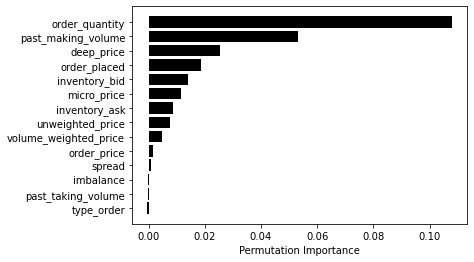

In [163]:
perm_importance = permutation_importance(clf, X_test, y_test)

sorted_idx = perm_importance.importances_mean.argsort()
plt.barh(X.columns[sorted_idx], perm_importance.importances_mean[sorted_idx], color='black')
plt.xlabel("Permutation Importance")

In [150]:
def rf_feat_importance(m, df):
    return pd.DataFrame({'cols':df.columns, 'imp':m.feature_importances_}
                       ).sort_values('imp', ascending=False)

def plot_fi(fi): return fi.plot('cols', 'imp', 'barh', color='black', figsize=(12,7), legend=False)

In [151]:
fi = rf_feat_importance(regr, X_train)

### MDI: Mean Decrease Impurity

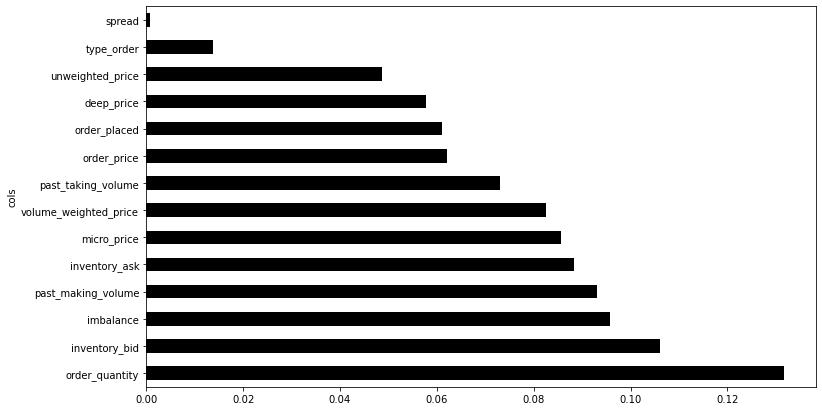

In [152]:
plot_fi(fi)

### Mean Decrease Accuracy

In [153]:
from sklearn.inspection import permutation_importance

In [154]:
perm_importance = permutation_importance(regr, X_test, y_test)


Text(0.5, 0, 'Permutation Importance')

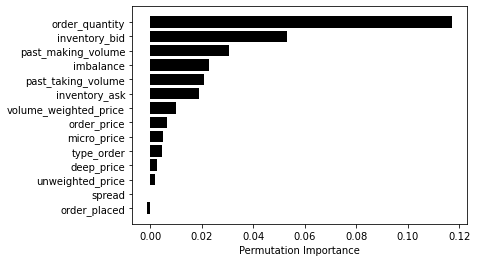

In [159]:
sorted_idx = perm_importance.importances_mean.argsort()
plt.barh(X.columns[sorted_idx], perm_importance.importances_mean[sorted_idx], color='black')
plt.xlabel("Permutation Importance")

### MultiClass Output

In [1002]:
y = df.iloc[:,14:]
X = df.iloc[:,:-7]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.4, random_state=42)


regr = RandomForestClassifier(max_depth=100, random_state=0)

from sklearn.multioutput import MultiOutputClassifier
from sklearn.multioutput import MultiOutputRegressor

multi_rfc = MultiOutputClassifier(regr) #.fit(X_train, y_train)

In [77]:
# from itertools import cycle


# y_score = multi_rfc.fit(X_train, y_train).predict_proba(X_test) #.decision_function(X_test)
# n_classes = y_train.shape[1]
# fpr = dict()
# tpr = dict()
# roc_auc = dict()
# for i in range(n_classes):
#     fpr[i], tpr[i], _ = roc_curve(y_test.iloc[:, i], y_score[i][:,1])
#     roc_auc[i] = roc_auc_score(y_test.iloc[:, i], y_score[i][:,1])
# colors = cycle(['blue', 'red', 'green', 'black', 'orange', 'yellow', 'darkolivegreen'])
# for i, color in zip(range(n_classes), colors):
#     plt.plot(fpr[i], tpr[i], color=color, lw=1.5,
#              label='ROC curve of class {0} (area = {1:0.4f})'
#              ''.format(i, roc_auc[i]))
# plt.plot([0, 1], [0, 1], 'k--', lw=1.5)
# plt.xlim([-0.05, 1.0])
# plt.ylim([0.0, 1.05])
# plt.xlabel('False Positive Rate')
# plt.ylabel('True Positive Rate')
# plt.title('Receiver operating characteristic for multi-class data')
# plt.legend(loc="lower right")
# plt.show()

In [1097]:
classes = df.iloc[:,14:]
X = df.iloc[:,:14]

for c in classes.columns:
    y = df[c]
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.4, random_state=42)
    rfc = RandomForestClassifier(max_depth=100, random_state=0).fit(X_train, y_train)
    print(f"Score of {c} class: {rfc.score(X_test, y_test)}")
    targets_proba_pred = rfc.predict_proba(X_test)[:,1]
    print(f"Area Under the ROC: {roc_auc_score(y_test, targets_proba_pred)}")
    print(f"Brier Score: {brier_score_loss(y_test, targets_proba_pred)}")
    print(f"-----------------------------------------------------------")

Score of execution_1e-05 class: 0.8921442369607212
Area Under the ROC: 0.9542486399472869
Brier Score: 0.08774591113972954
-----------------------------------------------------------
Score of execution_0.0001 class: 0.8921442369607212
Area Under the ROC: 0.9542486399472869
Brier Score: 0.08774591113972954
-----------------------------------------------------------
Score of execution_0.001 class: 0.8943979394719896
Area Under the ROC: 0.9549061348055977
Brier Score: 0.08738670315518351
-----------------------------------------------------------
Score of execution_0.01 class: 0.8869929169349646
Area Under the ROC: 0.9517075095586202
Brier Score: 0.09080798454603994
-----------------------------------------------------------
Score of execution_0.1 class: 0.8802318094011591
Area Under the ROC: 0.9461638243248012
Brier Score: 0.09673238892466195
-----------------------------------------------------------
Score of execution_1 class: 0.8795878943979395
Area Under the ROC: 0.9478179084396702
B

In [78]:
from xgboost import XGBClassifier
from sklearn.model_selection import cross_val_score
cross_val_score(XGBClassifier(), X, y)

array([0.66838377, 0.59497746, 0.56600129, 0.5878944 , 0.57179652])

In [79]:
model = XGBClassifier()
model = model.fit(X_train, y_train)
y_pred = model.predict(X_test)

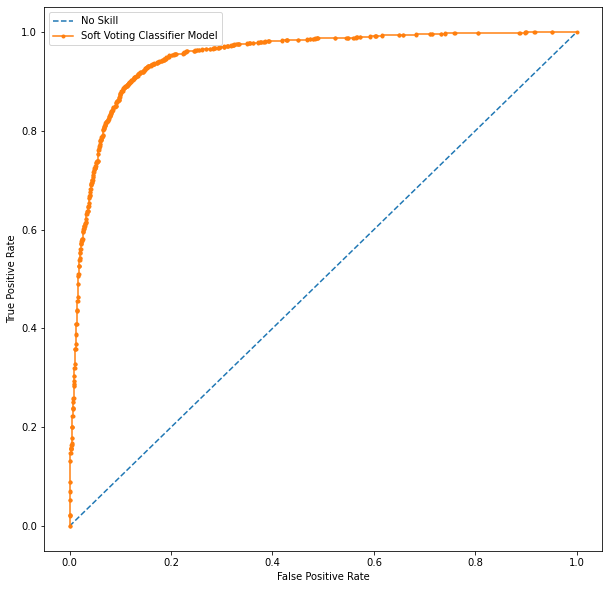

Area Under the ROC: 0.948816350097559
Brier Score: 0.08557518336408111


In [128]:
y = df['execution_full']
X = df.iloc[:,:-7]
X = log_sr_features
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.4, random_state=42)


regr =  XGBClassifier(max_depth=50, eval_metric='auc', objective='binary:logistic', nthread=10).fit(X_train, y_train)


ROC_curve(regr,y_test,X_test)

In [81]:
from sklearn.base import BaseEstimator, ClassifierMixin
from sklearn.neighbors import KernelDensity


class KDEClassifier(BaseEstimator, ClassifierMixin):
    """Bayesian generative classification based on KDE
    
    Parameters
    ----------
    bandwidth : float
        the kernel bandwidth within each class
    kernel : str
        the kernel name, passed to KernelDensity
    """
    def __init__(self, bandwidth=1, kernel='gaussian'):
        self.bandwidth = bandwidth
        self.kernel = kernel
        
    def fit(self, X, y):
        self.classes_ = np.sort(np.unique(y))
        training_sets = [X[y == yi] for yi in self.classes_]
        ''' Here i should incorporate multiple kernels'''
        self.models_ = [KernelDensity(bandwidth=self.bandwidth,
                                      kernel=self.kernel).fit(Xi)
                        for Xi in training_sets]

        self.logpriors_ = [np.log(Xi.shape[0] / X.shape[0])
                           for Xi in training_sets]
        return self
        
    def predict_proba(self, X):
        logprobs = np.array([model.score_samples(X)
                             for model in self.models_]).T
        result = np.exp(logprobs + self.logpriors_)
        return np.nan_to_num(result / result.sum(1, keepdims=True))
        
    def predict(self, X):
        return self.classes_[np.argmax(self.predict_proba(X), 1)]

In [82]:
np.seterr(divide='ignore', invalid='ignore')

{'divide': 'warn', 'over': 'warn', 'under': 'ignore', 'invalid': 'warn'}

In [129]:
from sklearn.datasets import load_digits
from sklearn.model_selection import GridSearchCV

# digits = load_digits()
y = df['execution_full']
X = df.iloc[:,:-7]
X = log_sr_features
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.4, random_state=42)

bandwidths = 20 ** np.linspace(-1, 2, 100)
grid = GridSearchCV(KDEClassifier(), {'bandwidth': bandwidths})
grid.fit(X_train, y_train)

scores = [val for val in grid.cv_results_['mean_test_score']]

{'bandwidth': 0.1486181397473029}
accuracy = 0.7950205833406324


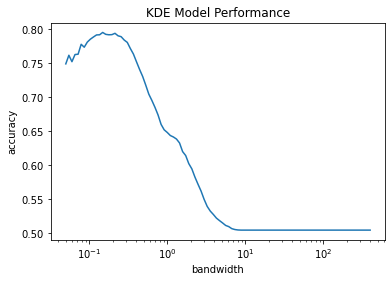

In [130]:
plt.semilogx(bandwidths, scores)
plt.xlabel('bandwidth')
plt.ylabel('accuracy')
plt.title('KDE Model Performance')
print(grid.best_params_)
print('accuracy =', grid.best_score_)

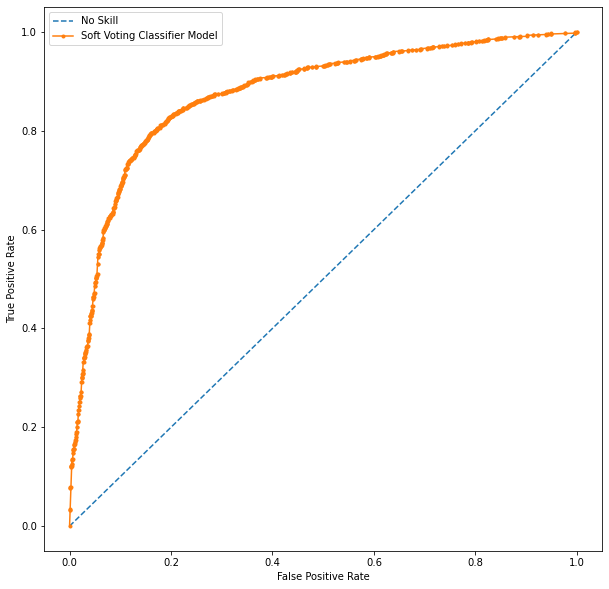

Area Under the ROC: 0.8751530581770398
Brier Score: 0.15162331738163243


In [131]:
ROC_curve(grid,y_test,X_test)

In [4]:
# from sklearn.metrics.pairwise import rbf_kernel, polynomial_kernel
# from MKLpy import generators
# from MKLpy.metrics import pairwise

# y = df['execution_full']
# X = df.iloc[:,:-7]
# RBF = rbf_kernel(X)
# POLY = polynomial_kernel(X)

# # KL_hpk = generators.HPK_generator(X.to_numpy(), degrees=range(1,11))

# # = my_generator.to_list()

In [3]:
# KL = KL_hpk.to_list()  #our list of base kernels (or a generator)
# KL = [RBF,POLY]
# # #usually, base kernels are normalize to prevent scaling and numerical issues
# # from MKLpy.preprocessing import kernel_normalization
# # KL_norm = [kernel_normalization(K) for K in KL]

# #let us divide trainig (70%) and test (30%) examples
# from MKLpy.model_selection import train_test_split
# KLtr, KLte, Ytr, Yte = train_test_split(KL, y, test_size=0.4, random_state=42)

In [2]:
# from MKLpy.algorithms import AverageMKL, EasyMKL
# #AverageMKL simply computes the average of input kernels
# #It looks bad but it is a really strong baseline in MKL ;)

# mkl = EasyMKL().fit(KLtr, Ytr.values)       #combine kernels and train the classifier
# # y_preds  = mkl.predict(KLte)            #predict the output class
# # y_scores = mkl.decision_function(KLte)  #returns the projection on the distance vector

In [1]:
# #evaluation with scikit-learn metrics
# from sklearn.metrics import accuracy_score, roc_auc_score
# accuracy = accuracy_score(Yte, y_preds)
# roc_auc = roc_auc_score(Yte, y_scores)
# print ('Accuracy score: %.4f, roc AUC score: %.4f' % (accuracy, roc_auc))